# Subspace BNN

In [2]:
import jax
import keras
import einops
import numpy as np
import pandas as pd
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt

from tqdm import tqdm
from matplotlib import ticker
from sklearn.datasets import make_moons
from sklearn.metrics import confusion_matrix

In [3]:
from rebayes_mini import callbacks
from rebayes_mini.methods import replay_sgd
from rebayes_mini.methods import kalman_filter as kf
from rebayes_mini.methods import subspace_filter as skf

In [5]:
import optax

from copy import deepcopy
from sklearn.decomposition import PCA
from flax.training.train_state import TrainState
from jax.flatten_util import ravel_pytree

## Drop-in replacement

In [6]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [7]:
plt.style.use("dark_background")

acolors = [
    "#D9117F",
    "#0DD9D9",
    "#F2A30F",
    "#F26E22",
]

colors = list(v["color"] for v in plt.rcParams["axes.prop_cycle"])

In [8]:
key = jax.random.PRNGKey(314)

In [6]:
n_samples = 500
n_test = 300
data = make_moons(n_samples=(n_samples + n_test), random_state=3141, noise=0.15)
X, y = jax.tree_map(jnp.array, data)
X_test, y_test = X[-n_test:], y[-n_test:]
X, y = X[:-n_test], y[:-n_test]

key = jax.random.PRNGKey(314)

In [ ]:
%%time
@skf.subcify
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(50)(x)
        x = nn.relu(x)
        x = nn.Dense(50)(x)
        x = nn.relu(x)
        x = nn.Dense(50)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x # Eta


model = MLP(dim_in=2, dim_subspace=50)
params = model.init(key, X)

agent = skf.BernoulliFilter(
    model.apply,
    dynamics_covariance=0.0
)

bel_init = agent.init_bel(params, cov=1.0)
bel, bel_hist = agent.scan(bel_init, y, X, callbacks.get_updated_mean)
bel = jax.block_until_ready(bel)
dim_full, _ = params["fixed"]["P"].shape

In [ ]:
yhat = jax.nn.sigmoid(agent.link_fn(bel.mean, X_test)) > 0.5
(y_test == yhat.ravel()).mean()

In [ ]:
plt.plot(bel_hist, alpha=0.4)
plt.axhline(y=0, c="white")
plt.grid(alpha=0.3)
plt.xlabel("Num. observations")
plt.ylabel("Weight value")

In [ ]:
XX = np.mgrid[-1.5:2:0.05, -1.5:2:0.05]

Xeval = einops.rearrange(XX, "d x y -> x y d")

Z = agent.link_fn(bel.mean, Xeval).squeeze()
mean_Z = agent.mean(Z)

plt.contourf(*XX, mean_Z, cmap="bone")
plt.contour(*XX, mean_Z > 0.5, colors="black", linestyles="--")
plt.scatter(*np.array(X).T, c=y, cmap="cool")
plt.ylim(-1.5, 2)
plt.xlim(-1.5, 2)
plt.axis("off")
plt.tight_layout()

## Test accuracy as a function of subspace

In [ ]:
%%time
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(50)(x)
        x = nn.relu(x)
        x = nn.Dense(50)(x)
        x = nn.relu(x)
        x = nn.Dense(50)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x # Eta


model = MLP()
params = model.init(key, X)

agent = kf.BernoulliFilter(
    model.apply,
    dynamics_covariance=0.0
)
bel_init = agent.init_bel(params, cov=0.1)
bel, _ = agent.scan(bel_init, y, X)
bel = jax.block_until_ready(bel)

In [ ]:
yhat = jax.nn.sigmoid(agent.link_fn(bel.mean, X_test)) > 0.5
acc_full = (y_test == yhat.ravel()).mean().item()
acc_full

In [ ]:
%%time
list_dim_subspace = np.arange(5, 155, 5)
SubMLP = skf.subcify(MLP)

n_runs = 15
results = []
keys = jax.random.split(key, n_runs)
for dim in tqdm(list_dim_subspace):
    model = SubMLP(dim_in=2, dim_subspace=dim)
    
    agent = skf.BernoulliFilter(
        model.apply,
        dynamics_covariance=0.0
    )
    
    @jax.vmap
    def eval_acc(key):
        params = model.init(key, X)
        bel_init = agent.init_bel(params, cov=2.0)
        bel, _ = agent.scan(bel_init, y, X)

        yhat = jax.nn.sigmoid(agent.link_fn(bel.mean, X_test)) > 0.5
        accuracy = (y_test == yhat.ravel()).mean()
        return accuracy
    
    accuracies = eval_acc(keys)
    results.append(accuracies)
results = pd.DataFrame(np.array(results), index=list_dim_subspace)

In [ ]:
fig, ax = plt.subplots()

vmin = results.quantile(0.1, axis=1)
vmax = results.quantile(0.9, axis=1)

results.quantile(axis=1).plot(ax=ax, marker="o", markersize=3)
ax.fill_between(results.index, vmin, vmax, alpha=0.3)
ax.axhline(y=acc_full, linestyle="--")
ax.text(20, acc_full * (1 - 0.01), "Full-dim EKF", verticalalignment="top")

_, ymax = plt.ylim()
plt.ylim(0.6, ymax)

plt.xlabel("subspace dimension")
plt.ylabel("Moon's test accuracy")
plt.grid(alpha=0.3)

In [ ]:
fig, ax = plt.subplots()

underperformance = results / acc_full - 1
underperformance.index = underperformance.index / dim_full
vmin = underperformance.quantile(0.1, axis=1)
vmax = underperformance.quantile(0.9, axis=1)

underperformance.quantile(axis=1).plot(ax=ax, marker="o", markersize=3)
ax.fill_between(underperformance.index, vmin, vmax, alpha=0.3)

_, ymax = plt.ylim()
plt.ylim(-0.4, ymax)

ax.axhline(y=0)
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:0.2%}"))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:0.0%}"))

plt.xlabel("% of total parameters")
plt.ylabel("% underperformance to\nfull covariance")
plt.grid(alpha=0.3)

--- 

# Fashion MNIST

In [20]:
from functools import partial

In [9]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
# X_train = einops.rearrange(X_train, "s w h -> s (w h)") / 255
# X_test = einops.rearrange(X_test, "s w h -> s (w h)") / 255
X_train = X_train[..., None] / 255
X_test = X_test[..., None] / 255 
y_train = jax.nn.one_hot(y_train, 10)
X_train = jnp.array(X_train)

In [206]:
X_eval = X_test[:5_000]
y_eval = y_test[:5_000]
def callbackfn(bel_update, bel_prev, y, x, agent):
    """
    Compute test accuracy at every timestep
    """
    yhat_eval = agent.link_fn(bel_update.mean, X_eval).argmax(axis=1)
    acc = (yhat_eval == y_eval).mean()
    return acc

## Subspace EKF

In [22]:
dim_in = (28, 28, 1)

In [23]:
class CNN(nn.Module):
    num_arms: int = 10

    @nn.compact
    def __call__(self, x):
        x = x if len(x.shape) > 3 else x[None, :]
        x = nn.Conv(features=6, kernel_size=(5, 5))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding="VALID")
        x = nn.Conv(features=16, kernel_size=(5, 5), padding="VALID")(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding="VALID")
        x = x.reshape((x.shape[0], -1))  # Flatten
        x = nn.Dense(features=120)(x)
        x = nn.relu(x)
        x = nn.Dense(features=84, name="last_layer")(x)  # There are 10 classes in MNIST
        x = nn.relu(x)
        x = nn.Dense(10, name="output_layer")(x)
        x = x - jax.nn.logsumexp(x)
        return x.squeeze()
    
model = CNN()

In [24]:
dim_subspace = 100
model = skf.subcify(CNN)(dim_in=dim_in, dim_subspace=dim_subspace)

key_params, key_fixed = jax.random.split(key)
params = model.init(key, X_train)

In [25]:
agent = skf.MultinomialFilter(
    model.apply,
    dynamics_covariance=1e-7
)

In [26]:
%%time
bel_init = agent.init_bel(params, cov=1e-3)

cfn = partial(callbackfn, agent=agent)
bel, hist_subspace_random = agent.scan(bel_init, y_train[:10_000], X_train[:10_000], cfn)
bel = jax.block_until_ready(bel)

CPU times: user 19.5 s, sys: 259 ms, total: 19.8 s
Wall time: 42.4 s


In [27]:
yhat_eval = agent.link_fn(bel.mean, X_eval).argmax(axis=1)
confusion_matrix(y_eval, yhat_eval)

array([[  0,   0, 507,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 481,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 521,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 500,   0,   0,   0,   0,   0,   0,   0],
       [  1,   0, 520,   0,   0,   0,   0,   0,   0,   0],
       [ 16,   7, 462,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 482,   0,   0,   0,   0,   0,   0,   0],
       [  0,   8, 492,   0,   0,   0,   0,   0,   0,   0],
       [  2,   0, 524,   0,   0,   0,   0,   0,   0,   0],
       [  0,  86, 391,   0,   0,   0,   0,   0,   0,   0]])

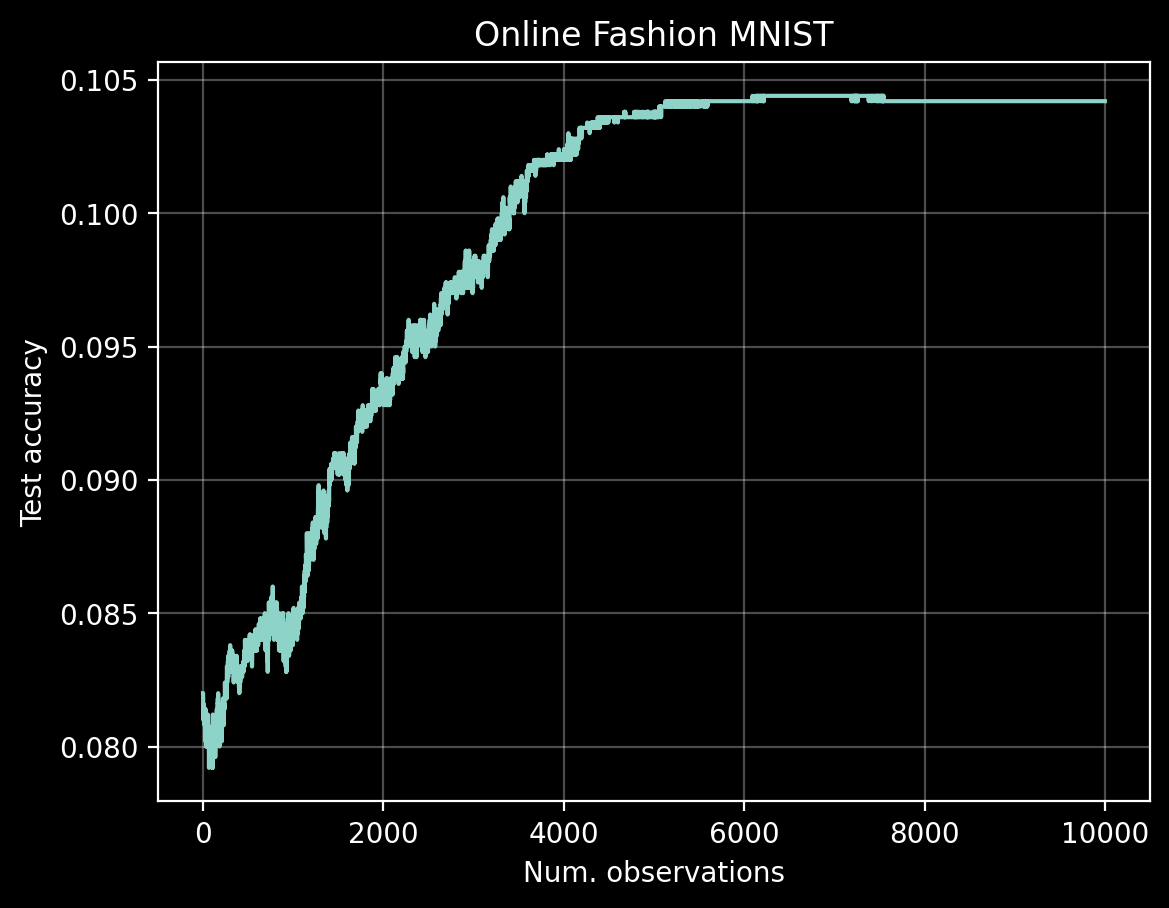

In [92]:
plt.plot(hist_subspace_random)

plt.xlabel("Num. observations")
plt.ylabel("Test accuracy")
plt.title("Online Fashion MNIST")
plt.grid(alpha=0.3)

## Subspace EKF with warmup

In [45]:
model = CNN()
def lossfn(params, X, y):
    yhat = model.apply(params, X)
    return -(y * yhat).sum(axis=1).mean()


def extract_hidden_layers(params):
    hidden_layers = deepcopy(params["params"])
    _ = hidden_layers.pop("output_layer")
    hidden_layers, _ = ravel_pytree(hidden_layers)
    return hidden_layers

In [46]:
X_warm = X_test[-2000:]
y_warm = jax.nn.one_hot(y_test[-2000:], 10)

In [47]:
pinit = model.init(key, X_train[:100])
state = TrainState.create(
    apply_fn=model.apply,
    params=pinit,
    tx=optax.adam(1e-3)
)

In [49]:
%%time
def warm_step(state, _):
    loss, grads = jax.value_and_grad(lossfn)(state.params, X_warm, y_warm)
    state = state.apply_gradients(grads=grads)
    
    params_flat, _ = ravel_pytree(state.params)
    # params_flat = extract_hidden_layers(state.params)
    output = {
        "params": params_flat,
        "loss": loss
    }
    return state, output

steps = jnp.arange(100)
state_final, hist_warmup = jax.lax.scan(warm_step, state, steps)

CPU times: user 21.9 s, sys: 537 ms, total: 22.4 s
Wall time: 12.1 s


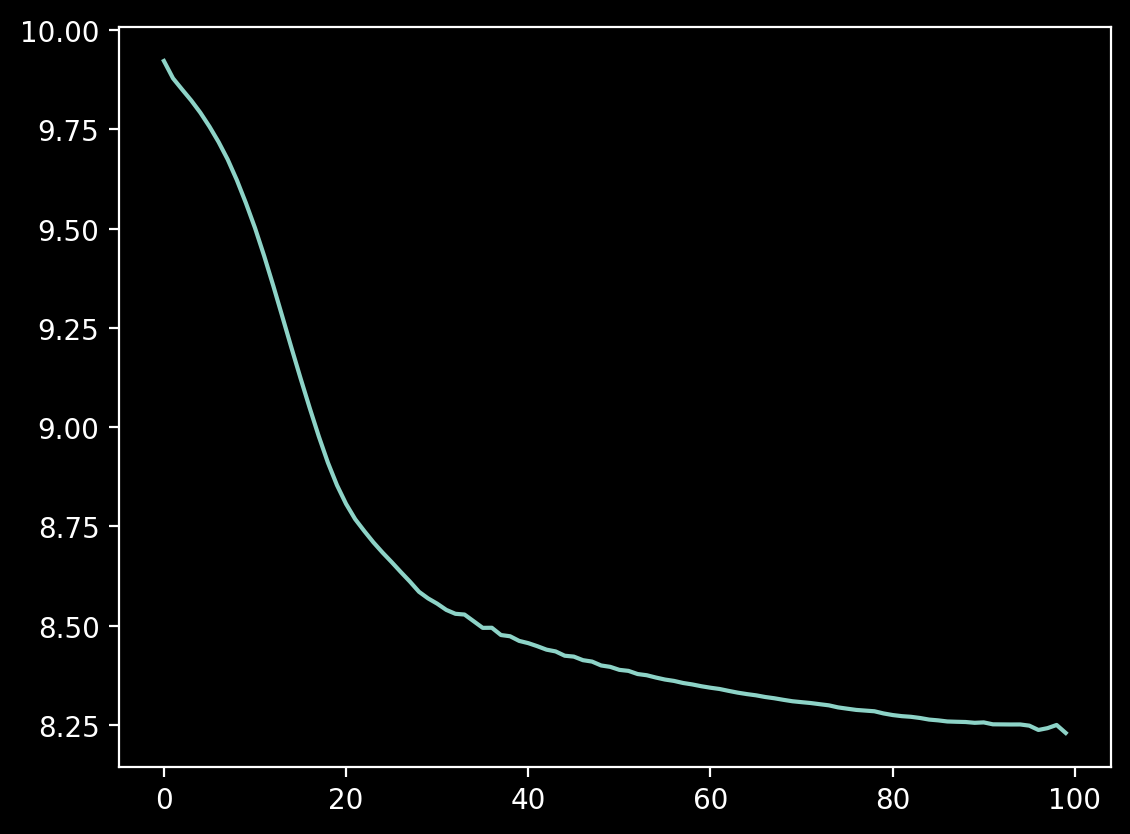

In [50]:
plt.plot(hist_warmup["loss"])

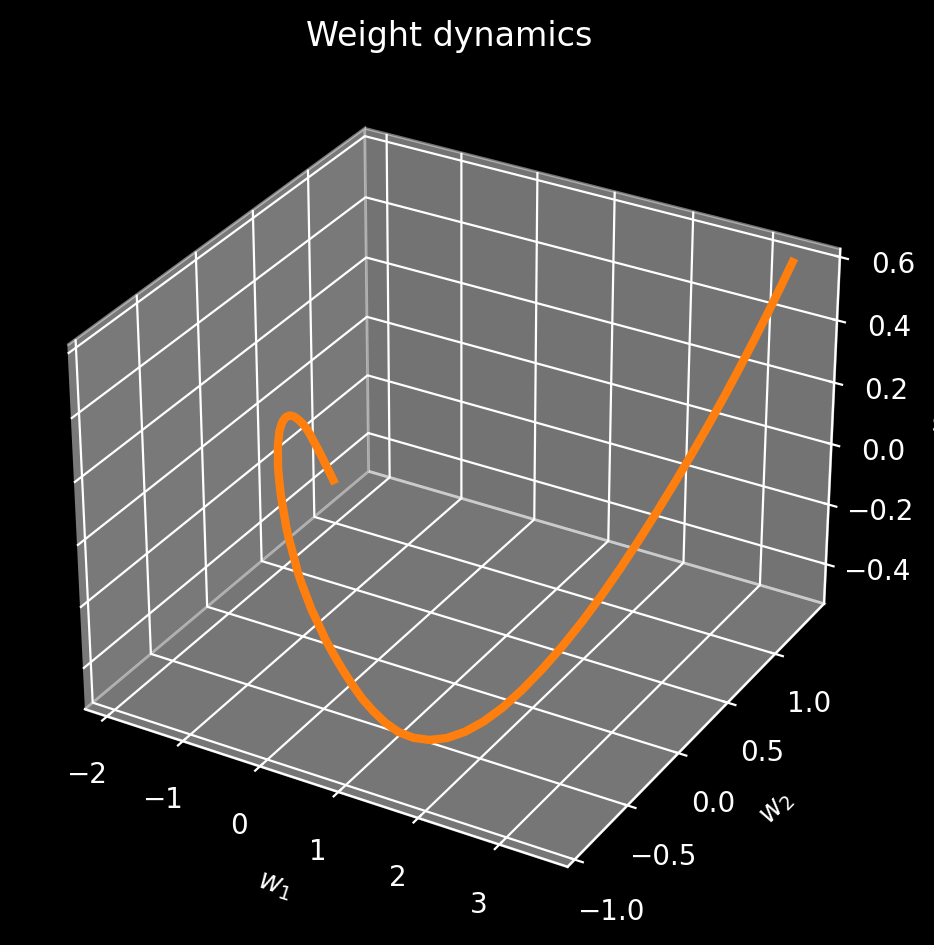

In [55]:
params_dynamics = np.array(hist_warmup["params"])

proj = PCA(n_components=3)
dynamics = proj.fit_transform(params_dynamics)

ax = plt.subplot(projection="3d")
plt.title("Weight dynamics")
ax.set_zlabel("$w_0$")
ax.set_xlabel("$w_1$")
ax.set_ylabel("$w_2$")
ax.plot(*dynamics.T, c="tab:orange", lw=3)
plt.tight_layout()

In [60]:
%%time
_, s, Vh = np.linalg.svd(params_dynamics, full_matrices=False)

projection_matrix = Vh[:dim_subspace, :].T
projection_matrix.shape

CPU times: user 1min 15s, sys: 1min, total: 2min 16s
Wall time: 1.49 s


(61706, 100)

## Subspace EKF

In [62]:
model = skf.subcify(CNN)(dim_in=dim_in, dim_subspace=dim_subspace)

key_params, key_fixed = jax.random.split(key)
params = model.init(key, X_train)

params["fixed"]["P"] = projection_matrix * 24

In [63]:
agent = skf.MultinomialFilter(
    model.apply,
    dynamics_covariance=1e-7
)

In [67]:
%%time
bel_init = agent.init_bel(params, cov=1e-3)

cfn = partial(callbackfn, agent=agent)
bel, hist_subspace_svd = agent.scan(bel_init, y_train[:10_000], X_train[:10_000], cfn)
bel = jax.block_until_ready(bel)

CPU times: user 20.9 s, sys: 292 ms, total: 21.2 s
Wall time: 42.7 s


In [68]:
yhat_eval = agent.link_fn(bel.mean, X_eval).argmax(axis=1)
confusion_matrix(y_eval, yhat_eval)

array([[384,   0,  67,  39,   0,   0,  11,   5,   1,   0],
       [245,   3,   4, 229,   0,   0,   0,   0,   0,   0],
       [150,   1, 159,  13,  14,   0, 181,   1,   2,   0],
       [110,  18,  26, 335,   0,   0,   5,   4,   1,   1],
       [211,   2,  58,  62,  37,   0, 147,   1,   2,   1],
       [  0,   0, 210,   3,   5,   0,  28, 175,   1,  63],
       [208,   3, 147,  28,  11,   0,  83,   2,   0,   0],
       [  0,   0,  38,   0,   0,   0,   0, 441,   0,  21],
       [ 32,   2, 273,  18,   8,   0,  65,  79,  46,   3],
       [  0,   0,   0,   0,   0,   0,   1,  82,   0, 394]])

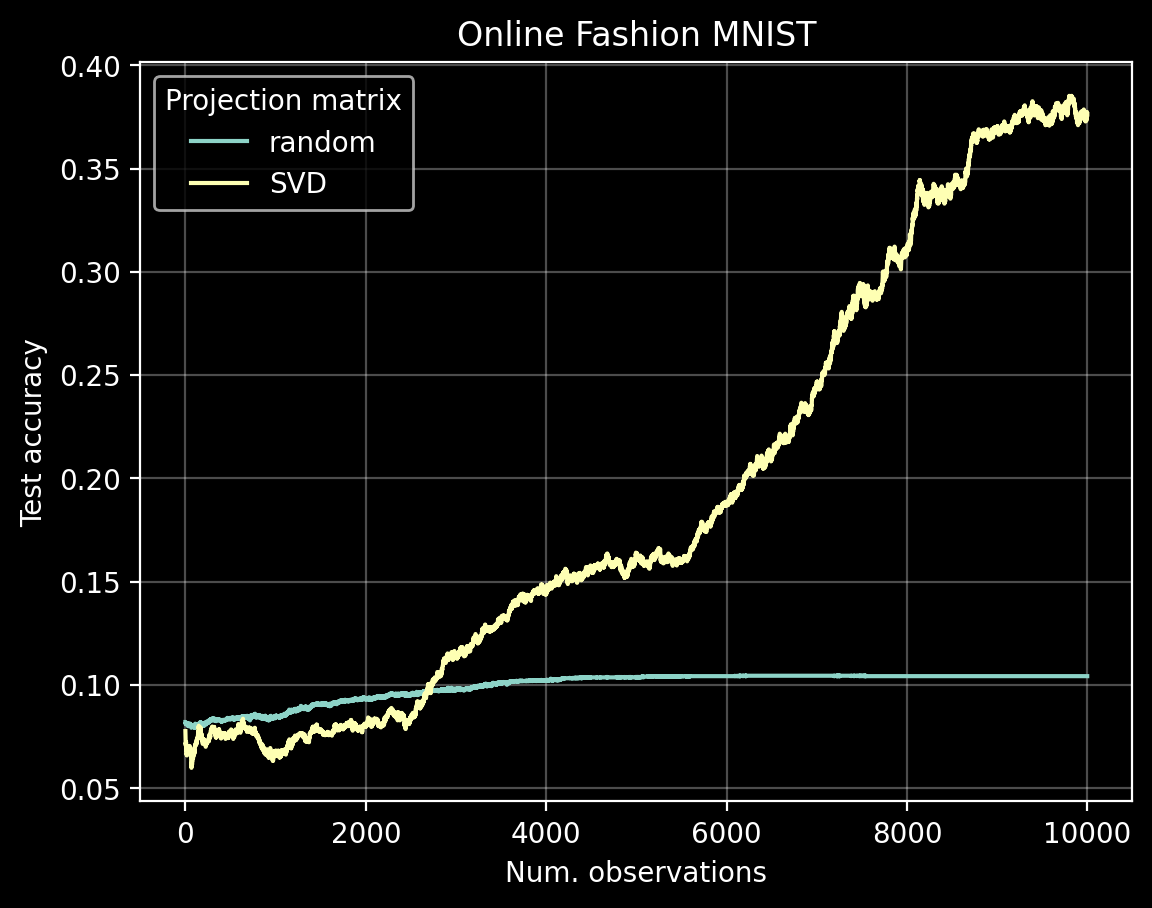

In [94]:
plt.plot(hist_subspace_random, label="random")
plt.plot(hist_subspace_svd, label="SVD")
plt.legend(title="Projection matrix")


plt.xlabel("Num. observations")
plt.ylabel("Test accuracy")
plt.title("Online Fashion MNIST")
plt.grid(alpha=0.3)

## PULSE

In [75]:
%%time
# @skf.subcify
class CNNHidden(nn.Module):
    num_arms: int = 10

    @nn.compact
    def __call__(self, x):
        x = x if len(x.shape) > 3 else x[None, :]
        x = nn.Conv(features=6, kernel_size=(5, 5))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding="VALID")
        x = nn.Conv(features=16, kernel_size=(5, 5), padding="VALID")(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding="VALID")
        x = x.reshape((x.shape[0], -1))  # Flatten
        x = nn.Dense(features=120)(x)
        x = nn.relu(x)
        x = nn.Dense(features=84)(x)
        x = nn.relu(x)
        return x.squeeze()

    

class PULSE(nn.Module):
    dim_in: int
    dim_subspace: int

    @nn.compact
    def __call__(self, x):
        x = skf.subcify(CNNHidden)(self.dim_in, self.dim_subspace)(x)
        x = nn.Dense(10)(x)
        x = x - jax.nn.logsumexp(x)
        return x

CPU times: user 1.57 ms, sys: 0 ns, total: 1.57 ms
Wall time: 1.8 ms


In [76]:
dim_in = (28, 28, 1)
dim_subspace = 100
model = PULSE(dim_in=dim_in, dim_subspace=dim_subspace)

key_params, key_fixed = jax.random.split(key)
params = model.init({"params": key_params, "fixed": key_fixed}, X_train)

In [83]:
structure = jax.tree_map(jnp.shape, params)
print(json.dumps(structure, indent=2))

{
  "fixed": {
    "SubspaceModule_0": {
      "P": [
        60856,
        100
      ],
      "b": [
        60856
      ]
    }
  },
  "params": {
    "Dense_0": {
      "bias": [
        10
      ],
      "kernel": [
        84,
        10
      ]
    },
    "SubspaceModule_0": {
      "subspace": [
        100
      ]
    }
  }
}


In [84]:
agent = skf.MultinomialFilter(
    model.apply,
    dynamics_covariance=1e-7
)

In [88]:
%%time
bel_init = agent.init_bel(params, cov=1e-3)
cfn = partial(callbackfn, agent=agent)
bel, hist_pulse_prandom = agent.scan(bel_init, y_train[:10_000], X_train[:10_000], cfn)
bel = jax.block_until_ready(bel)

CPU times: user 31.2 s, sys: 939 ms, total: 32.1 s
Wall time: 2min 20s


In [89]:
yhat_eval = agent.link_fn(bel.mean, X_eval).argmax(axis=1)
confusion_matrix(y_eval, yhat_eval)

array([[261,  17,   5,  49,   7,   3, 154,   0,  11,   0],
       [  0, 446,   4,  21,   3,   0,   7,   0,   0,   0],
       [  0,   0, 245,   8, 115,   0, 143,   0,  10,   0],
       [ 11,  41,   2, 358,  41,   0,  43,   0,   4,   0],
       [  0,   7, 134,  31, 276,   2,  64,   0,   6,   1],
       [  0,   3,   1,   9,   0, 311,   3,  83,  40,  35],
       [ 45,  12,  85,  25,  75,   2, 219,   0,  19,   0],
       [  0,   0,   0,   0,   0,  30,   0, 376,  11,  83],
       [  1,   2,   4,   8,   3,   4,  12,   2, 488,   2],
       [  0,   3,   0,   4,   0,  11,   0,   9,   6, 444]])

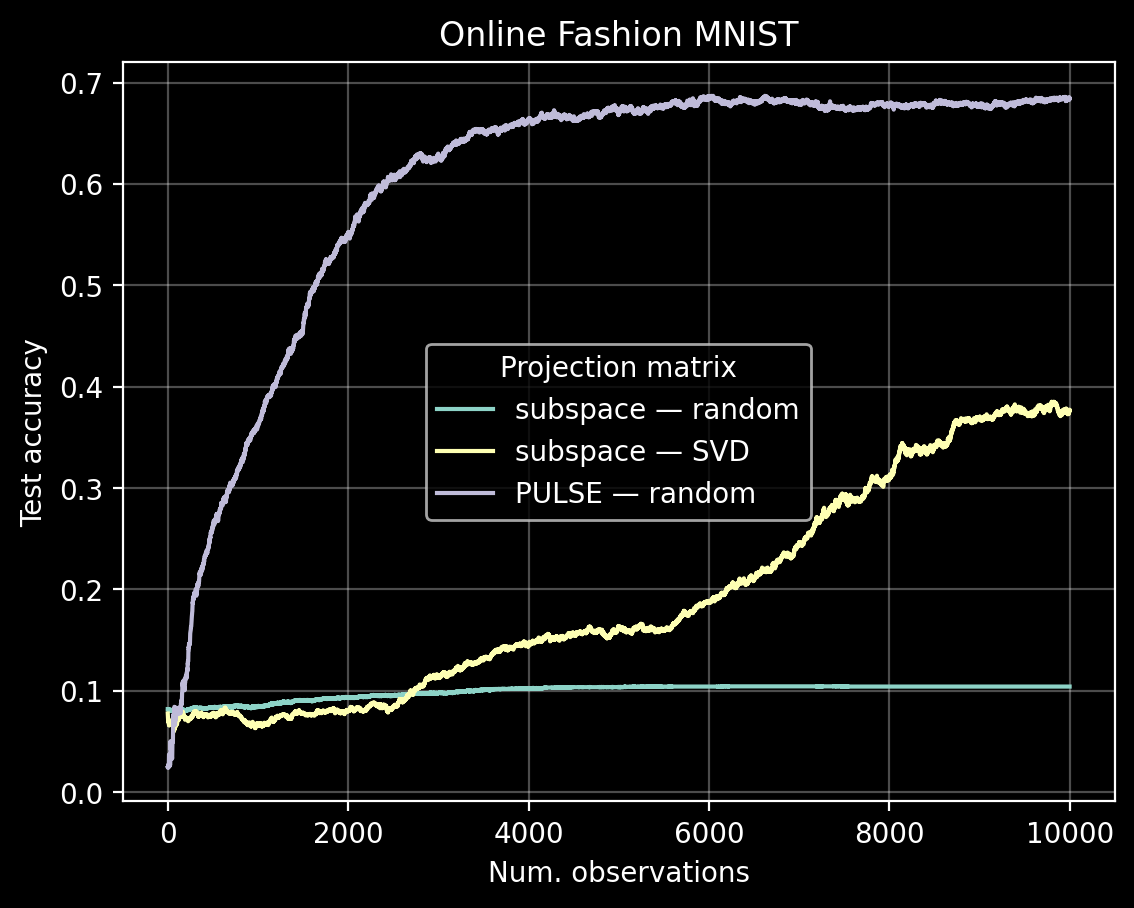

In [91]:
plt.plot(hist_subspace_random, label="subspace — random")
plt.plot(hist_subspace_svd, label="subspace — SVD")
plt.plot(hist_pulse_prandom, label="PULSE — random")
plt.legend(title="Projection matrix")


plt.xlabel("Num. observations")
plt.ylabel("Test accuracy")
plt.title("Online Fashion MNIST")
plt.grid(alpha=0.3)

## SVD PULSE

In [168]:
model = CNN()
def lossfn(params, X, y):
    yhat = model.apply(params, X)
    return -(y * yhat).sum(axis=1).mean()


def extract_hidden_layers(params):
    hidden_layers = deepcopy(params["params"])
    _ = hidden_layers.pop("output_layer")
    hidden_layers, _ = ravel_pytree(hidden_layers)
    return hidden_layers

In [180]:
X_warm = X_test[-1000:]
y_warm = jax.nn.one_hot(y_test[-1000:], 10)

In [181]:
pinit = model.init(key, X_train[:100])
state = TrainState.create(
    apply_fn=model.apply,
    params=pinit,
    tx=optax.adam(1e-3)
)

In [182]:
%%time
def warm_step(state, _):
    loss, grads = jax.value_and_grad(lossfn)(state.params, X_warm, y_warm)
    state = state.apply_gradients(grads=grads)
    
    # params_flat, _ = ravel_pytree(state.params)
    params_flat = extract_hidden_layers(state.params)
    output = {
        "params": params_flat,
        "loss": loss
    }
    return state, output

steps = jnp.arange(100)
state_final, hist_warmup = jax.lax.scan(warm_step, state, steps)

CPU times: user 2min 34s, sys: 1.11 s, total: 2min 35s
Wall time: 2min 8s


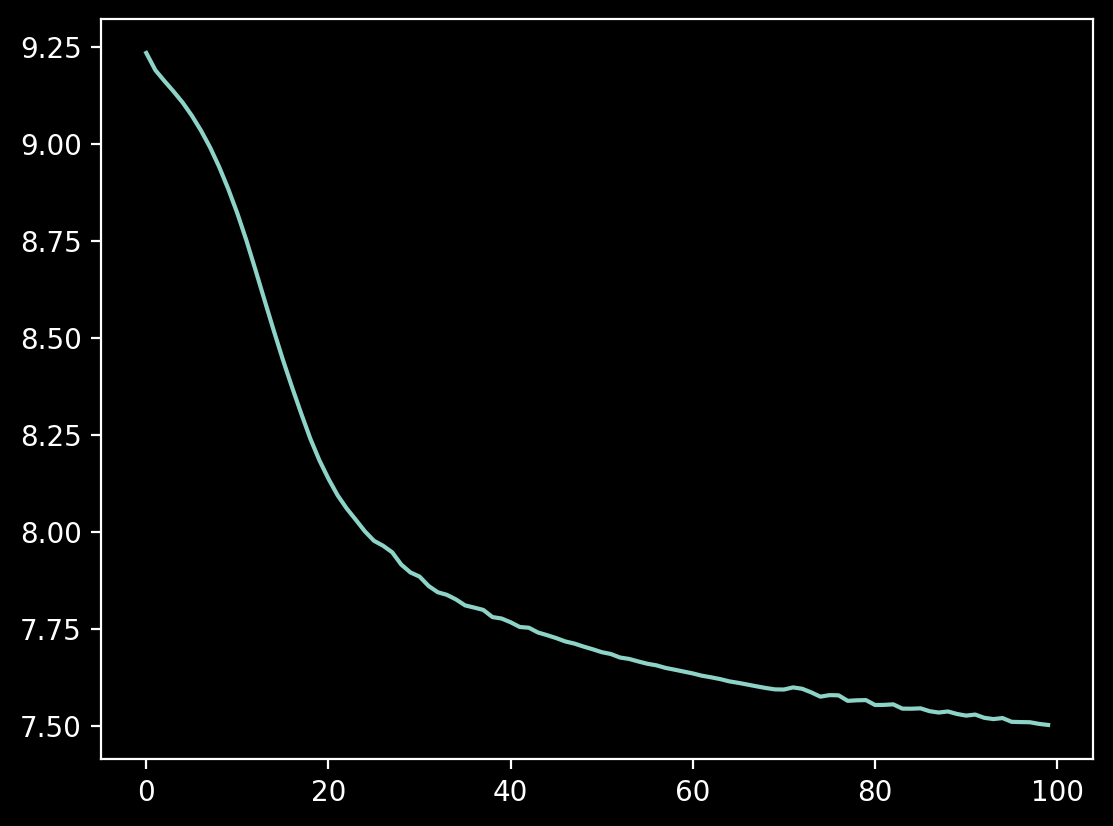

In [183]:
plt.plot(hist_warmup["loss"])

In [214]:
dim_subspace = 100

In [215]:
%%time
params_dynamics = hist_warmup["params"]
_, s, Vh = np.linalg.svd(params_dynamics, full_matrices=False)

projection_matrix = Vh[:dim_subspace, :].T
projection_matrix.shape

CPU times: user 1min 13s, sys: 1min 8s, total: 2min 21s
Wall time: 1.6 s


(60856, 100)

In [216]:
model = PULSE(dim_in=dim_in, dim_subspace=dim_subspace)

key_params, key_fixed = jax.random.split(key)
params = model.init({"params": key_params, "fixed": key_fixed}, X_train)

In [219]:
params["fixed"]["SubspaceModule_0"]["P"] = projection_matrix * 50
params = jax.tree_map(jnp.array, params) # Place back to TPU

In [220]:
agent = skf.MultinomialFilter(
    model.apply,
    dynamics_covariance=1e-7
)

In [221]:
%%time
bel_init = agent.init_bel(params, cov=1e-3)
cfn = partial(callbackfn, agent=agent)
bel, hist_pulse_svd = agent.scan(bel_init, y_train[:10_000], X_train[:10_000], cfn)
bel = jax.block_until_ready(bel)

CPU times: user 58.2 s, sys: 1.55 s, total: 59.8 s
Wall time: 5min 32s


In [222]:
yhat_eval = agent.link_fn(bel.mean, X_eval).argmax(axis=1)
confusion_matrix(y_eval, yhat_eval)

array([[368,   6,   3,  52,   4,  10,  59,   1,   4,   0],
       [  1, 406,   7,  58,   3,   0,   6,   0,   0,   0],
       [  4,   1, 324,   5,  65,   1, 117,   0,   4,   0],
       [ 19,   8,   0, 401,  23,   0,  48,   0,   1,   0],
       [  0,   3, 190,  35, 238,   4,  48,   0,   2,   1],
       [  0,   0,   0,   1,   0, 391,   0,  74,   1,  18],
       [ 91,   5, 114,  37,  43,  10, 173,   1,   8,   0],
       [  0,   0,   0,   0,   0,  36,   0, 420,   0,  44],
       [  0,   2,  10,  10,   1,  14,  23,  16, 448,   2],
       [  0,   0,   0,   1,   0,  27,   0,  24,   0, 425]])

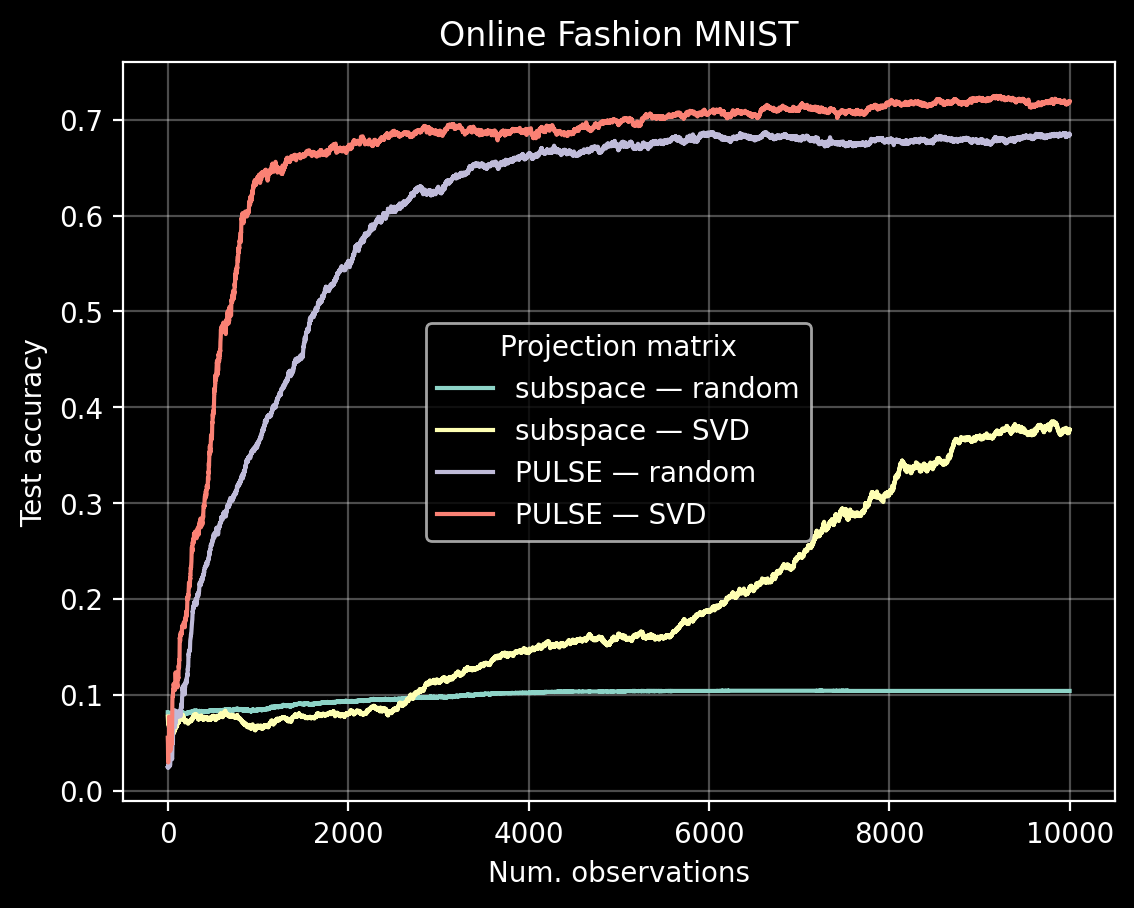

In [225]:
plt.plot(hist_subspace_random, label="subspace — random")
plt.plot(hist_subspace_svd, label="subspace — SVD")
plt.plot(hist_pulse_prandom, label="PULSE — random")
plt.plot(hist_pulse_svd, label="PULSE — SVD")
plt.legend(title="Projection matrix")


plt.xlabel("Num. observations")
plt.ylabel("Test accuracy")
plt.title("Online Fashion MNIST")
plt.grid(alpha=0.3)

## What about replay-sgd?

In [228]:
X_eval = X_test[:5_000]
y_eval = y_test[:5_000]
def callbackfn(bel_update, bel_prev, y, x, agent):
    """
    Compute test accuracy at every timestep
    """
    yhat_eval = agent.apply_fn(bel_update.mean, X_eval).argmax(axis=1)
    acc = (yhat_eval == y_eval).mean()
    return acc

In [229]:
model = CNN()

In [230]:
def lossfn_fifo_sgd(params, counter, x, y, applyfn):
    yhat = applyfn(params, x)
    num = -(y * yhat).sum(axis=1) * counter
    return num.sum() / counter.sum()

In [231]:
agent = replay_sgd.FifoSGD(
    model.apply,
    lossfn_fifo_sgd,
    optax.adam(1e-3),
    buffer_size=1,
    dim_features=(28, 28, 1),
    dim_output=10,
    n_inner=1
)

In [234]:
params_init = model.init(key, X_train[:10])

In [235]:
bel_init = agent.init_bel(params_init)

In [ ]:
%%time
cfn = partial(callbackfn, agent=agent)
bel_sgd, hist_rsgd = agent.scan(bel_init, y_train[:10_000], X_train[:10_000], cfn)
bel_sgd = jax.block_until_ready(bel_sgd)

In [ ]:
plt.plot(hist_subspace_random, label="subspace — random")
plt.plot(hist_subspace_svd, label="subspace — SVD")
plt.plot(hist_pulse_prandom, label="PULSE — random")
plt.plot(hist_pulse_svd, label="PULSE — random")
plt.plot(hist_rsgd, label="OGD")

plt.legend(title="Projection matrix")


plt.xlabel("Num. observations")
plt.ylabel("Test accuracy")
plt.title("Online Fashion MNIST")
plt.grid(alpha=0.3)